In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
import os

# sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# pytorch
import torch
from torch.optim import Adam
from torch import nn

# BERT from Huggingface
from transformers import BertTokenizer
from transformers import BertModel

# Extra additional packages/functions
from updated_balancers import BinaryBalancer
from utils import calculate_bias_metrics, eo_postprocess, calc_gen_bounds, BertClassifier, train, Dataset

In [2]:
# Import fifa 20 dataset
all_data = pd.read_csv('players_20.csv')
# all_data.head()

In [3]:
# Set the nationalities you want to use
nationalities = ['England','Argentina']

# Keep relevant columns
o_data = all_data[['long_name','age','nationality','overall','wage_eur']].copy(deep = True)

# Change column names of nationality and wage_eur to a and y 
o_data.rename(columns = {'nationality':'a', 'wage_eur':'y'}, inplace = True)

# Restrict to specified nationalities
o_data = o_data.loc[(o_data['a'].isin([nationalities[0], nationalities[1]]))]
print('Number of players:', o_data.shape[0])

# Only keep relevant feagires and outcomes
data = o_data[['long_name','age','a','overall','y']].copy(deep = True)

# Binarize nationality
data = data.replace(nationalities[0],0)
data = data.replace(nationalities[1],1)

# Reset the index
data = data.reset_index(drop=True)

# Binarize outcome using median outcome
data.loc[data['y'] < np.median(data['y']), 'y'] = 0
data.loc[data['y'] >= np.median(data['y']), 'y'] = 1
# data.head()

Number of players: 2553


In [4]:
# Create new column to stratify data and calculate base rates
group = []
for i in range(data.shape[0]):
    # w
    if np.sum(data[['a','y']].iloc[i] == [0,0]) == 2:
        group.append(1)
    # v
    if np.sum(data[['a','y']].iloc[i] == [1,0]) == 2:
        group.append(2)
    # s
    if np.sum(data[['a','y']].iloc[i] == [0,1]) == 2:
        group.append(3)
    # r
    if np.sum(data[['a','y']].iloc[i] == [1,1]) == 2:
        group.append(4)

# Add column to the data
data['group'] = group

# Calculate base rates
total = data.shape[0]
r = np.sum(data['group'] == 4)/total
s = np.sum(data['group'] == 3)/total
v = np.sum(data['group'] == 2)/total
w= np.sum(data['group'] == 1)/total
print('min rate = ', min(r,s,w,v))

min rate =  0.11711711711711711


In [7]:
# Experiment Parameters
EPOCHS = 5
model = BertClassifier()
LR = 1e-6 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# Splitting data into necessary datasets
d_xa, d_remain = train_test_split(data, train_size = 0.7, stratify=data['group'],random_state=10)

In [13]:
# Split d_xa into d_xa_train and d_xa_val
d_xa_train, d_xa_val = train_test_split(d_xa, train_size = 0.75, stratify=d_xa['group'],random_state=10)

# Train model
train(model, d_xa_train, d_xa_val, LR, EPOCHS)

100%|██████████| 670/670 [00:32<00:00, 20.86it/s]


Epochs: 1 | Train Loss:  0.011             | Train Accuracy:  0.997             | Val Loss:  0.022             | Val Accuracy:  0.996


100%|██████████| 670/670 [00:34<00:00, 19.61it/s]


Epochs: 2 | Train Loss:  0.005             | Train Accuracy:  0.999             | Val Loss:  0.023             | Val Accuracy:  0.996


100%|██████████| 670/670 [00:34<00:00, 19.63it/s]


Epochs: 3 | Train Loss:  0.007             | Train Accuracy:  0.999             | Val Loss:  0.023             | Val Accuracy:  0.996


100%|██████████| 670/670 [00:36<00:00, 18.25it/s]


Epochs: 4 | Train Loss:  0.006             | Train Accuracy:  0.998             | Val Loss:  0.024             | Val Accuracy:  0.996


100%|██████████| 670/670 [00:34<00:00, 19.59it/s]


Epochs: 5 | Train Loss:  0.004             | Train Accuracy:  0.999             | Val Loss:  0.025             | Val Accuracy:  0.996


In [14]:
# Retrain using all data
d_xa_train, d_xa_val = train_test_split(d_xa, train_size = 0.99, stratify=d_xa['group'],random_state=10)

# Train model
train(model, d_xa_train, d_xa_val, LR, EPOCHS)

100%|██████████| 885/885 [00:45<00:00, 19.45it/s]


Epochs: 1 | Train Loss:  0.016             | Train Accuracy:  0.996             | Val Loss:  0.001             | Val Accuracy:  1.000


100%|██████████| 885/885 [00:45<00:00, 19.38it/s]


Epochs: 2 | Train Loss:  0.010             | Train Accuracy:  0.998             | Val Loss:  0.001             | Val Accuracy:  1.000


100%|██████████| 885/885 [00:45<00:00, 19.40it/s]


Epochs: 3 | Train Loss:  0.012             | Train Accuracy:  0.997             | Val Loss:  0.001             | Val Accuracy:  1.000


100%|██████████| 885/885 [00:45<00:00, 19.38it/s]


Epochs: 4 | Train Loss:  0.011             | Train Accuracy:  0.997             | Val Loss:  0.001             | Val Accuracy:  1.000


100%|██████████| 885/885 [00:46<00:00, 19.20it/s]

Epochs: 5 | Train Loss:  0.006             | Train Accuracy:  0.997             | Val Loss:  0.001             | Val Accuracy:  1.000


In [33]:
# Controlling fairness
# Leave hold out data to evaluate fairness on
d_train, d_xy_test = train_test_split(d_remain, train_size = 0.7, stratify=d_remain['group'], random_state=10)

# Using BERT on test set to generate a_hat
a = d_xy_test['a']
xy_test = Dataset(d_xy_test)
xy_test_dataloader = torch.utils.data.DataLoader(xy_test, batch_size=len(xy_test))
device = torch.device("cpu")
model.to(device)
model = model.eval()
with torch.no_grad():
    for xy_test_input, xy_test_label, xy_test_remain in xy_test_dataloader:
        xy_test_label = xy_test_label.to(device).float()
        mask = xy_test_input['attention_mask'].to(device)
        input_id = xy_test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask).reshape(1,-1)[0]
a_hat = (np.array(output) >= 0.5).astype('float')
a_error = 1 - (np.sum(a_hat == a)/len(a))
print('U = ', a_error)

U =  0.021739130434782594


In [35]:
x_test = d_xy_test[['age','overall']]
y_test = d_xy_test['y'].to_numpy()

# make empty lists to store results
u_bound_tpr_pre = []
u_bound_tpr_post = []
u_bound_fpr_pre = []
u_bound_fpr_post = []

for i in tqdm(range(100)):
    # Sample a subset of the original training set
    d_xy_train = d_train.sample(frac=0.8)

    # Create Classifier
    clf = RandomForestClassifier(n_estimators=50)

    # Split data into features and labels
    x_train = d_xy_train[['age','overall']]
    y_train = d_xy_train['y']

    # Fit classifier
    clf.fit(x_train.to_numpy(),y_train)

    # Evaluate probabilities/y_hat on test set
    y_prob = clf.predict_proba(x_test.to_numpy())
    
    # Calculate y_hat
    y_hat = (y_prob[:,1] >= 0.5).astype('float')

    # Calculate bias metrics with respect to a_hat
    balancer_h = BinaryBalancer(y=y_test, a=a_hat, y_=y_hat)
    alpha_h, beta_h, tau_h, phi_h = calculate_bias_metrics(balancer_h)

    # Calculating initial bounds
    # Computing the upper bounds before 
    ub1_t, ub2_t = calc_gen_bounds(alpha_h,beta_h,a_error,r,s)
    ub1_f, ub2_f = calc_gen_bounds(tau_h,phi_h,a_error,v,w)
    u_bound_tpr_pre.append(max(np.abs(ub1_t),np.abs(ub2_t)))
    u_bound_fpr_pre.append(max(np.abs(ub1_f),np.abs(ub2_f)))

    # Learn fair f
    fair_yh, fair_model = eo_postprocess(y_test,y_hat,a_hat)

    # Use fair model to predict on 
    fair_yh = fair_model.predict(y_hat,a_hat)
    balancer_fair = BinaryBalancer(y=y_test, a=a_hat, y_=fair_yh)
    alpha_h, beta_h, tau_h , phi_h = calculate_bias_metrics(balancer_fair)

    # Computing the upper bounds after 
    ub1_t, ub2_t = calc_gen_bounds(alpha_h,beta_h,a_error,r,s)
    ub1_f, ub2_f = calc_gen_bounds(tau_h,phi_h,a_error,v,w)
    u_bound_tpr_post.append(max(np.abs(ub1_t),np.abs(ub2_t)))
    u_bound_fpr_post.append(max(np.abs(ub1_f),np.abs(ub2_f)))

u_bound_tpr_pre = np.array(u_bound_tpr_pre)
u_bound_fpr_pre = np.array(u_bound_fpr_pre)
u_bound_tpr_post = np.array(u_bound_tpr_post)
u_bound_fpr_post = np.array(u_bound_fpr_post)

100%|██████████| 100/100 [00:05<00:00, 18.68it/s]


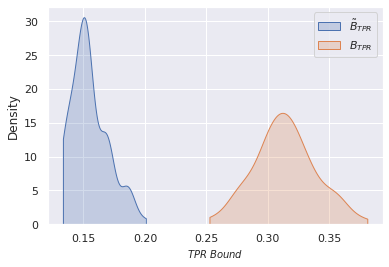

In [45]:
# Generate KDE Plots
sns.kdeplot(u_bound_tpr_post, shade = True, label = r'$\tilde{B}_{TPR}$',cut = 0)
sns.kdeplot(u_bound_tpr_pre, shade = True, label = r'$B_{TPR}$',cut = 0)
plt.legend()
plt.xlabel(r'$TPR\ Bound$', fontsize=10)
plt.savefig('Figures/newExp3/real_data_tpr_control_Eng_Arg',bbox_inches="tight")

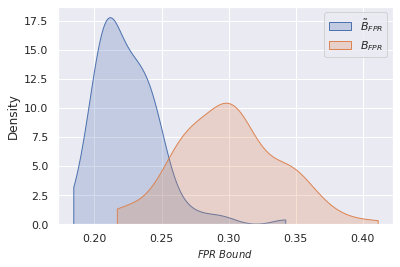

In [46]:
# Generate KDE Plots
sns.kdeplot(u_bound_fpr_post, shade = True, label = r'$\tilde{B}_{FPR}$',cut = 0)
sns.kdeplot(u_bound_fpr_pre, shade = True, label = r'$B_{FPR}$',cut = 0)
plt.legend()
plt.xlabel(r'$FPR\ Bound$', fontsize=10)
plt.savefig('Figures/newExp3/real_data_fpr_control_Eng_Arg',bbox_inches="tight")